# setup

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

from tensorflow.python.keras.utils.data_utils import Sequence

sklearn version:  1.0.2
TF version:  2.8.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


# Get the data

In [10]:
#작성자 전민재
import csv
def load_Emist(exsitNumpy=False, needTranspose=True):
    if (exsitNumpy == False):
        #"./emnist-byclass-test.csv"
        #train-set
        #"공용/datasets/Emnist/" 위치에 csv 저장 
        csv_train_data_file = open("./train_data.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        csv_train_label_file = open("./train_label.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
    
        
        f_train = csv.reader(csv_train_data_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        l_train=csv.reader(csv_train_label_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        #valid-set
    
        csv_valid_data_file = open("./valid_data.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        csv_valid_label_file = open("./valid_label.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        
        f_valid = csv.reader(csv_valid_data_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        l_valid = csv.reader(csv_valid_label_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        X_train=[]
        y_train=[]
        X_valid=[]
        y_valid=[]
        for i, row in enumerate(f_train):
            #행마다 int로 형변환
            for idx, char in enumerate(row):
                row[idx]=int(char)
            #train
            #data 추가    
            X_train.append(row)
            
        for i, row in enumerate(f_valid):
            #행마다 int로 형변환
            for idx, char in enumerate(row):
                row[idx]=int(char)
            #valid
            #data 추가    
            X_valid.append(row)


        for i, row in enumerate(l_train):

            #train
            #label 추가
            y_train.append(int(row[0]))
            
        for i, row in enumerate(l_valid):

            #valid
            #label 추가
            y_valid.append(int(row[0]))
            
            
        

        #train
        X_train=np.array(X_train,dtype=np.uint8)
        X_train=X_train.reshape(-1,28,28)
        #valid
        X_valid=np.array(X_valid,dtype=np.uint8)
        X_valid=X_valid.reshape(-1,28,28)
        
        csv_train_data_file.close()
        csv_train_label_file.close()
        csv_valid_data_file.close()
        csv_valid_label_file.close()
        
        #kaggle dataset이 시계반대방향으로 90도 회전 되있고 상하 반전 되어있음
        def rotate_90(m):
            N = len(m)
            ret = [[0] * N for _ in range(N)]

            for r in range(N):
                for c in range(N):
                    ret[c][N-1-r] = m[r][c]
            return np.array(ret,dtype=np.uint8)

        def vreflect(m):
            N = len(m)
            ret = [[0] * N for _ in range(N)]

            for r in range(N):
                for c in range(N):
                    ret[r][c] = m[r][N-1-c]
            return np.array(ret,dtype=np.uint8)
        
        if needTranspose == True:
            #train
            #회전
            for idx,i in enumerate(X_train):
                X_train[idx]=rotate_90(i)
            #상하반전
            for idx,i in enumerate(X_train):
                X_train[idx]=vreflect(i)

            #valid
            #회전
            for idx,i in enumerate(X_valid):
                X_valid[idx]=rotate_90(i)
            #상하반전
            for idx,i in enumerate(X_valid):
                X_valid[idx]=vreflect(i)

       
        
        
        #저장용
        #train
        #(533917,28,28)
        np.save('./X_train',X_train)
        np.save('./y_train',y_train)
        #valid
        np.save('./X_valid',X_valid)
        np.save('./y_valid',y_valid)
        
   
    X_train=np.load('./X_train.npy')
    y_train=np.load('./y_train.npy')
    X_valid=np.load('./X_valid.npy')
    y_valid=np.load('./y_valid.npy')
    
    return X_train, y_train, X_valid, y_valid


In [11]:
#황성현
#npy 파일이 존재할 경우 exsitNumpy = True, 업으면 False
X_train, y_train, X_valid, y_valid = load_Emist(exsitNumpy=True)
X_train.shape,X_train.dtype

((533917, 28, 28), dtype('int32'))

In [12]:
X_train_letters = X_train[np.where(y_train>10)]

In [13]:
y_train_letters = y_train[np.where(y_train>10)]

In [14]:
for i in range (3):
    X_train = np.append(X_train,X_train_letters,axis=0)
    y_train = np.append(y_train, y_train_letters,axis=0)

In [15]:
X_train.shape

(1329679, 28, 28)

In [16]:
import gc
del X_train_letters, y_train_letters
gc.collect


<function gc.collect(generation=2)>

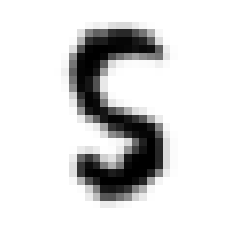

28


In [17]:
#이승훈
import cv2 as cv
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
ids=1
X_new=X_train[ids]
y_new=y_train[ids]
c=X_new.reshape(28,28)


plt.imshow(c, cmap="binary")
plt.axis('off')
plt.show()
print(y_new)

# Prepare the data

In [18]:
#황성현
#data, batch size 성정
train_size=len(X_train)
valid_size=len(X_valid)
batch_size=32
train_size

1329679

In [19]:
#황성현
X_train=np.reshape(X_train,[-1,784])
X_valid=np.reshape(X_valid,[-1,784])
X_train.shape,X_valid.shape

((1329679, 784), (164015, 784))

In [20]:
#황성현
y_train=np.reshape(y_train,[-1,1])
y_valid=np.reshape(y_valid,[-1,1])

y_train.shape,y_valid.shape

((1329679, 1), (164015, 1))

In [21]:
n_inputs = X_train.shape[-1]
print("n_inputs =",n_inputs)

n_inputs = 784


In [26]:
#황성현
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    
    Emnist_dir = os.path.join("./EMNIST/datasets", "Emnist")
    os.makedirs(Emnist_dir, exist_ok=True)
    path_format = os.path.join(Emnist_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        try:
            with open(part_csv, "xt", encoding="utf-8") as f:
                if header is not None:
                    f.write(header)
                    f.write("\n")
                for row_idx in row_indices:
                    f.write(",".join([repr(col) for col in data[row_idx]]))
                    f.write("\n")
        except:
            continue
    return filepaths

In [27]:
train_full=np.append(X_train,y_train,axis=1)

In [28]:
train_full.shape

(1329679, 785)

In [29]:
#황성현
train_filepaths = save_to_multiple_csv_files(train_full, "train", n_parts=20)

In [30]:
valid_full=np.append(X_valid,y_valid,axis=1)

In [31]:
#황성현

valid_filepaths = save_to_multiple_csv_files(valid_full, "valid", n_parts=20)

In [33]:
#황성현
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

def dataaugmentation(X):
    datagen=ImageDataGenerator(rotation_range=40,width_shift_range = 0.2, 
        height_shift_range = 0.2)
    #영어 부분 2배 생성
    #차원변환 
    X=tf.reshape(X,[28,28,1])

    #새로운 데이터 생성
    angle=(random.random()%1)*0.8 - 0.4
    image_result =tfa.image.rotate(X, tf.constant(angle))#rotate -pi/10 ~ pi/10
    shift=(random.random()%1)*2 - 1
    image_result=tfa.image.translate(image_result,[tf.constant(shift),tf.constant(shift)])
    
    return image_result

In [34]:
#황성현
@tf.function
def preprocess_mobilenet_v2(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.mobilenet_v2.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_resnet50(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.resnet50.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_vgg16(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.vgg16.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_renet(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
   
    return augment_image, y

@tf.function
def preprocess_xception(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.xception.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_inception_v3(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.inception_v3.preprocess_input(resized_image)
    
    return final_image, y

In [35]:
#황성현
from enum import Enum
class eModelName(Enum):
    mobilenet_v2 = 0,
    resnet50 = 1,
    vgg16 = 3,
    renet = 4,
    xception = 5,
    inception_v3 = 6
    

In [36]:
#황성현
from functools import partial
def csv_reader_dataset(filepaths, model_name, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32,randomize=True):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    if model_name == eModelName.mobilenet_v2:
        dataset = dataset.map(partial(preprocess_mobilenet_v2,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.resnet50:
        dataset = dataset.map(partial(preprocess_resnet50,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.vgg16:
        dataset = dataset.map(partial(preprocess_vgg16,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.renet:
        dataset = dataset.map(partial(preprocess_renet,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.xception:
        dataset = dataset.map(partial(preprocess_xception,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.inception_v3:
        dataset = dataset.map(partial(preprocess_inception_v3,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [37]:
#황성현
#csv_reader_dataset의 파라미터 model_name에 eModelNAme class의 맴버 변수 중 사용할 모델 입력
#ex) model_name = eModelName.inception_v3, model_name = eModelName.renet 
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, model_name = eModelName.inception_v3, batch_size=batch_size, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths, model_name = eModelName.inception_v3, 
                               batch_size=batch_size, repeat=None, randomize = False)
train_set,valid_set

inception_v3
inception_v3


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>)

# Inception-v3 by 박민성, 황성현

In [38]:
n_classes=62
base_model=tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)
avg=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output=keras.layers.Dense(n_classes, activation='softmax')(avg)
model_inceptionv3=keras.models.Model(inputs=base_model.input, outputs=output)

87924736/87910968 [==============================] - 4s 0us/step


In [39]:
model_inceptionv3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

                                                                                                  
 average_pooling2d (AveragePool  (None, None, None,   0          ['max_pooling2d_1[0][0]']        
 ing2D)                         192)                                                              
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, None,   12288       ['max_pooling2d_1[0][0]']        
                                64)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   76800       ['activation_6[0][0]']           
                                64)                                                               
                                                                                                  
 conv2d_10

                                                                                                  
 conv2d_18 (Conv2D)             (None, None, None,   16384       ['average_pooling2d_1[0][0]']    
                                64)                                                               
                                                                                                  
 batch_normalization_12 (BatchN  (None, None, None,   192        ['conv2d_12[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_normalization_14 (BatchN  (None, None, None,   192        ['conv2d_14[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_25 (BatchN  (None, None, None,   192        ['conv2d_25[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_19 (Activation)     (None, None, None,   0           ['batch_normalization_19[0][0]'] 
                                64)                                                               
                                                                                                  
 activation_21 (Activation)     (None, None, None,   0           ['batch_normalization_21[0][0]'] 
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   114688      ['activation_35[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_31 (BatchN  (None, None, None,   384        ['conv2d_31[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 batch_normalization_36 (BatchN  (None, None, None,   384        ['conv2d_36[0][0]']              
 ormalization)                  128)                                                              
          

 ormalization)                  160)                                                              
                                                                                                  
 activation_44 (Activation)     (None, None, None,   0           ['batch_normalization_44[0][0]'] 
                                160)                                                              
                                                                                                  
 conv2d_45 (Conv2D)             (None, None, None,   179200      ['activation_44[0][0]']          
                                160)                                                              
                                                                                                  
 batch_normalization_45 (BatchN  (None, None, None,   480        ['conv2d_45[0][0]']              
 ormalization)                  160)                                                              
          

 activation_48 (Activation)     (None, None, None,   0           ['batch_normalization_48[0][0]'] 
                                192)                                                              
                                                                                                  
 activation_49 (Activation)     (None, None, None,   0           ['batch_normalization_49[0][0]'] 
                                192)                                                              
                                                                                                  
 mixed5 (Concatenate)           (None, None, None,   0           ['activation_40[0][0]',          
                                768)                              'activation_43[0][0]',          
                                                                  'activation_48[0][0]',          
                                                                  'activation_49[0][0]']          
          

 batch_normalization_53 (BatchN  (None, None, None,   576        ['conv2d_53[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_58 (BatchN  (None, None, None,   576        ['conv2d_58[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_59 (BatchN  (None, None, None,   576        ['conv2d_59[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_50 (Activation)     (None, None, None,   0           ['batch_normalization_50[0][0]'] 
          

 conv2d_60 (Conv2D)             (None, None, None,   147456      ['mixed6[0][0]']                 
                                192)                                                              
                                                                                                  
 conv2d_63 (Conv2D)             (None, None, None,   258048      ['activation_62[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_68 (Conv2D)             (None, None, None,   258048      ['activation_67[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_69 (Conv2D)             (None, None, None,   147456      ['average_pooling2d_6[0][0]']    
          

 batch_normalization_71 (BatchN  (None, None, None,   960        ['conv2d_71[0][0]']              
 ormalization)                  320)                                                              
                                                                                                  
 batch_normalization_75 (BatchN  (None, None, None,   576        ['conv2d_75[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_71 (Activation)     (None, None, None,   0           ['batch_normalization_71[0][0]'] 
                                320)                                                              
                                                                                                  
 activation_75 (Activation)     (None, None, None,   0           ['batch_normalization_75[0][0]'] 
          

                                384)                                                              
                                                                                                  
 activation_79 (Activation)     (None, None, None,   0           ['batch_normalization_79[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_82 (Activation)     (None, None, None,   0           ['batch_normalization_82[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_83 (Activation)     (None, None, None,   0           ['batch_normalization_83[0][0]'] 
                                384)                                                              
          

 ormalization)                  384)                                                              
                                                                                                  
 batch_normalization_92 (BatchN  (None, None, None,   1152       ['conv2d_92[0][0]']              
 ormalization)                  384)                                                              
                                                                                                  
 conv2d_93 (Conv2D)             (None, None, None,   393216      ['average_pooling2d_8[0][0]']    
                                192)                                                              
                                                                                                  
 batch_normalization_85 (BatchN  (None, None, None,   960        ['conv2d_85[0][0]']              
 ormalization)                  320)                                                              
          

In [40]:
for layer in base_model.layers:

    layer.trainable = False

model_inceptionv3.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",

              metrics=["accuracy"])

 

check_best_cb = tf.keras.callbacks.ModelCheckpoint("inceptionv3_best_nadam.h5",save_best_only=True)

check_last_cb = tf.keras.callbacks.ModelCheckpoint("inceptionv3_last_nadam.h5",save_best_only=False)

 

history = model_inceptionv3.fit(train_set,

                    steps_per_epoch=int(train_size / batch_size),

                    validation_data=valid_set,

                    validation_steps=int(valid_size / batch_size),

                    epochs=2,callbacks=[check_best_cb,check_last_cb])

Epoch 1/2
41552/41552 [==============================] - 3434s 82ms/step - loss: 0.7048 - accuracy: 0.7717 - val_loss: 0.6932 - val_accuracy: 0.7655
Epoch 2/2
41552/41552 [==============================] - 3305s 80ms/step - loss: 0.6284 - accuracy: 0.7902 - val_loss: 0.5978 - val_accuracy: 0.8065


In [ ]:
import datetime as dt

for layer in base_model.layers:

    layer.trainable = True

model_inceptionv3.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",

              metrics=["accuracy"])

 

check_best_cb = tf.keras.callbacks.ModelCheckpoint("inceptionv3_best_nadam.h5",save_best_only=True)

check_last_cb = tf.keras.callbacks.ModelCheckpoint("inceptionv3_last_nadam.h5",save_best_only=False)

logs = "logs/" + dt.datetime.now().strftime("inceptionv3%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,

                                                 histogram_freq = 1,

                                                 profile_batch = '500,520')

early_stop_cb=tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
 

history = model_inceptionv3.fit(train_set,

                    steps_per_epoch=int(train_size / batch_size),

                    validation_data=valid_set,

                    validation_steps=int(valid_size / batch_size),

                    epochs=300,callbacks=[check_best_cb,check_last_cb,tboard_callback,early_stop_cb])

Epoch 1/300
41552/41552 [==============================] - 13513s 325ms/step - loss: 0.4299 - accuracy: 0.8418 - val_loss: 0.4227 - val_accuracy: 0.8290
Epoch 2/300
41552/41552 [==============================] - 13593s 327ms/step - loss: 0.3400 - accuracy: 0.8680 - val_loss: 0.3453 - val_accuracy: 0.8691
Epoch 3/300
41552/41552 [==============================] - 13890s 334ms/step - loss: 0.2791 - accuracy: 0.8896 - val_loss: 0.4147 - val_accuracy: 0.8530
Epoch 4/300
41552/41552 [==============================] - 12686s 305ms/step - loss: 0.2088 - accuracy: 0.9155 - val_loss: 0.5007 - val_accuracy: 0.8454
Epoch 5/300
41552/41552 [==============================] - 12691s 305ms/step - loss: 0.1370 - accuracy: 0.9460 - val_loss: 0.6078 - val_accuracy: 0.8460
Epoch 6/300
41552/41552 [==============================] - 13450s 324ms/step - loss: 0.1040 - accuracy: 0.9596 - val_loss: 0.6380 - val_accuracy: 0.8518
Epoch 7/300
41552/41552 [==============================] - 13968s 336ms/step - los